# Fair Outlier Detector

This notebook shows a simple example on how to use the `FairOD` model to detect anomalies taking into consideration fairness. We also compare a normal/base outlier detector (`BaseOD`) with the proposed model.

Paper:


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../src')

from fairsgod.losses import FairODLoss
from fairsgod.fairod import OutlierDetector
from fairsgod.fairod_sg import SGOutlierDetector
from fairsgod import evaluation


First we load,preprocess and split the credit dataset which contains information of customers credit cards. 

The protected variable (PV) is age where customers older than 25 form the majority group and those younger the minority group. The minority group under-represented.

The outliers are those customers that default hence their label is Y=1.

In [2]:
# load credit
credit_df = pd.read_csv('../datasets/proc/crafted_credit.csv')

y_pv = credit_df[['OUTLIER','PV']]
X = credit_df.drop(columns=['OUTLIER', 'AGE', 'PV'])

X_train, X_test, y_pv_train, y_pv_test = train_test_split(X, y_pv, test_size=0.3, shuffle=True)

pv_test = y_pv_test['PV']
pv_train = y_pv_train['PV']
y_test = y_pv_test['OUTLIER']

In [3]:
credit_df.head(3)

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,-0.832115,-0.738428,0.593918,0.532005,0.499606,0.634237,0.508760,0.571115,-1.000000,-0.681879,...,0,1,0,0,0,0,0,0,0,0
1,-0.222207,-0.588964,0.592961,0.530502,0.500993,0.637064,0.513098,0.573617,-1.000000,-0.647868,...,0,0,0,1,0,0,0,0,0,0
2,-0.340833,-0.126025,0.610132,0.541779,0.507072,0.644415,0.523736,0.581394,-0.574467,-0.607786,...,0,0,1,0,0,0,0,0,0,0


The idea behind the FairOD model is to detect outliers regardless of what group samples belong to, so we don't want to detect outlier in the minority group just because they are under-presented.

The paper describes criteria to help carry out a fair detection. 

1. `Treatment Parity`: an outlier detection independent of the PV, achieved by not using the PV during training or detection. 

2. `Statistical Parity`: equal detection probability per PV group, achieved by minimising the correlation between the outlier score (or reconstruction error) and the PV.

3. `Group Fidelity`: equal rate of true outliers detected, achived by enforcing the same ranking of outlier scores given by the BaseOD

These last two are taken care of in the custom loss function:

                        L  =  alpha * L_base  +  (1 - alpha) * L_sp  +  gamma * L_gf

L_base: Reconstruction error (or outlier scores), in this notebook we will use the MSE

L_sp: Statistical Parity term which aims to minimise the correlation between the outlier scores and the PV.
        Thus, the probability of a sample being flagged as an outlier is the the same per PV group.

L_gf: Group Fidelity term looks at enforcing the ranking of outlier scores of BaseOD so that TRUE outliers are detected with the same probability per group.


Now, we build the models.

The `FairOD` model is an autoencoder built for outlier detection in an unsupervised setting (don't use OUTLIER variable in training).

In [4]:
n_inputs = len(X_train.columns)

optimizer = tf.keras.optimizers.Adam()

## BaseOD
base_loss_fn = tf.keras.losses.MeanSquaredError()

# create autoencoder 
inputs = tf.keras.Input(shape=(n_inputs,))
encoder = tf.keras.layers.Dense(n_inputs)(inputs)
embedding = tf.keras.layers.Dense(2)(encoder)
decoder = tf.keras.layers.Dense(n_inputs, activation='linear')(embedding)
baseOD = tf.keras.Model(inputs=inputs, outputs=decoder)

# compile model
baseOD.compile(optimizer=optimizer, loss=base_loss_fn)

In [5]:
## FairOD
fair_loss_fn = FairODLoss(alpha=0.1, gamma=0.1)

# create autoencoder 
inputs = tf.keras.Input(shape=(n_inputs,))
encoder = tf.keras.layers.Dense(n_inputs)(inputs)
embedding = tf.keras.layers.Dense(2)(encoder)
decoder = tf.keras.layers.Dense(n_inputs, activation='tanh')(embedding)
fairOD = tf.keras.Model(inputs=inputs, outputs=decoder)

# compile model
fairOD.compile(optimizer=optimizer, loss=fair_loss_fn)

**Train the BASE AUTOENCODER**

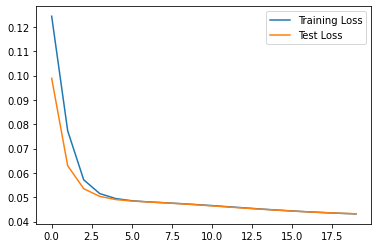

In [6]:
# Train baseOD
epochs=20
history = baseOD.fit(X_train, X_train, epochs=epochs, batch_size=256, validation_data=(X_test,X_test), verbose=0)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.legend()

Now, the **FairOD** version

In [10]:
def training(X_train, pv_train, X_test, pv_test, model, optimizer, loss_fn, batch_size=256, epochs=10):

    # Prepare datsets
    train_dataset, val_dataset = prepare_dataset(X_train, pv_train, X_test, pv_test, batch_size)

    # Initialise arrays to store losses during training and at validation
    train_loss_results = np.zeros(shape=(epochs,), dtype=np.float32)
    test_loss_results = np.zeros(shape=(epochs,), dtype=np.float32)

    # TRAINING
    for epoch in range(epochs):
        # reset loss avg at each epoch
        train_loss_avg = tf.keras.metrics.Mean()
        test_loss_avg = tf.keras.metrics.Mean()

        # Iterate over batches 
        for step, (X_batch_train, pv_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                X_batch_pred = model(X_batch_train, training=True)
                loss_value = loss_fn(X_batch_train, X_batch_pred, pv_batch_train)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Update avg loss
            train_loss_avg(loss_value)

        # Save training loss
        train_loss_results[epoch] = train_loss_avg.result()

        # Run a validation loop at the end of each epoch
        for X_batch_test, pv_batch_test in val_dataset:
            test_pred = model(X_batch_test, training=False)
            test_loss_value = loss_fn(X_batch_test, test_pred, pv_batch_test)
            # Update avg loss
            test_loss_avg(test_loss_value)
        # Save test loss
        test_loss_results[epoch] = test_loss_avg.result()

    return train_loss_results, test_loss_results


def prepare_dataset(X_train, pv_train, X_test, pv_test, batch_size):
    # Prepare training datsets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, pv_train))
    train_dataset = train_dataset.batch(batch_size)

    # Prepare validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test, pv_test))
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset



def plot_losses(train_loss_results, test_loss_results):
    # Plot losses during training and test
    results = pd.DataFrame({'epochs': tf.linspace(1., len(test_loss_results), len(test_loss_results)), 'Test_Loss':test_loss_results, 'Train_Loss':train_loss_results})
    plt.plot(results.epochs, results.Train_Loss, label='Training Loss')
    plt.plot(results.epochs, results.Test_Loss, label='Test Loss')
    plt.legend()
    plt.xlabel('Epochs');
    plt.ylabel('FairLoss');
    plt.show()
    return 

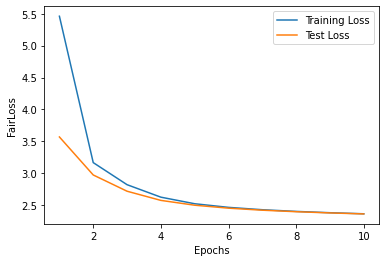

In [11]:
# Train fairOD
train_results, test_results = training(X_train, pv_train, X_test, pv_test, 
                                        fairOD, optimizer, fair_loss_fn, batch_size=512, epochs=10)
                    
plot_losses(train_results, test_results)

Pass the testing split of the dataset throught the models.
Then compute the outlier scores: SUM( MSE(X_i) ).

In [14]:
# predict baseOD
X_pred_base = baseOD.predict(X_test)

# compute reconstruction error 
os_base = evaluation.compute_outlier_scores(X_test, X_pred_base)
pred_df = pd.DataFrame({'OS_base':os_base, 'True_class': y_test})

In [16]:
# predict fairOD
X_pred_fair = fairOD.predict(X_test)

# compute reconstruction error 
os_fair = evaluation.compute_outlier_scores(X_test, X_pred_fair)
pred_df['OS_fair'] = os_fair

Now that we have, the true outlier labels (y_test), the PV (pv_test) and the outlier scores for both models (os_base and os_fair), we can compute the fairness metrics and compare the models.

In [18]:
base_metrics = [evaluation.compute_AP_ratio(y_test, os_base, pv_test), evaluation.compute_precision_ratio(y_test, os_base, pv_test),evaluation.compute_Fairness_metric(y_test, os_base, pv_test).numpy(), evaluation.compute_GF_metric(os_base, pv_test).numpy(), evaluation.compute_rankAgreement_metric(y_test, os_base, os_base)]
fair_metrics = [evaluation.compute_AP_ratio(y_test, os_fair, pv_test), evaluation.compute_precision_ratio(y_test, os_fair, pv_test), evaluation.compute_Fairness_metric(y_test, os_fair, pv_test).numpy(), evaluation.compute_GF_metric(os_fair, pv_test).numpy(), evaluation.compute_rankAgreement_metric(y_test, os_base, os_fair)]

results = pd.DataFrame()
results['Metrics'] = ['AP ratio', 'Precision ratio', 'Fairness', 'Group Fidelity', 'Rank Agreement']
results['baseOD'] = base_metrics
results['fairOD'] = fair_metrics
results['In paper fairOD'] = ['0.9-1.5', '0.9-1.5', '0.8-1', '-', '0.4-1']

results

,Metrics,baseOD,fairOD,In paper fairOD
0,AP ratio,0.921336,0.929689,0.9-1.5
1,Precision ratio,0.857771,0.922526,0.9-1.5
2,Fairness,0.890188,0.929364,0.8-1
3,Group Fidelity,1.113167,1.111465,-
4,Rank Agreement,1.000000,0.644807,0.4-1


For all these metrics the ideal value is 1. This means it classifies samples as outliers equally between groups and hence is fair! 

In these results we see that fairOD tends to do slightly better than baseOD. Note also that our results are similar very close to those on presented in the paper.

Now, AUC score...

In [19]:
from sklearn.metrics import roc_auc_score

In [20]:
print("AUC baseOD  ", roc_auc_score(y_test, os_base))
print("AUC fairOD  ", roc_auc_score(y_test, os_fair))

AUC baseOD   0.678514504699269
AUC fairOD   0.6819612052497408


The autoencoder regularized with the FAIROD terms, seems to have similar predictive power

# Automated version!

This repo contains the former functionality wrapped inside a class: `OutlierDetector`

**FairOD Base**

In [33]:
model = OutlierDetector(alpha=0.1, gamma=0.1)
_, _ = model.fit(X_train, pv_train, batch_size=512, epochs=3, val_X=X_test, val_pv=pv_test)

In [34]:
from sklearn.metrics import roc_auc_score

# save predictions
X_pred = model.predict_scores(X_test).numpy()

# AUC score
print("AUC score:   ", roc_auc_score(y_test, X_pred))

AUC score:    0.6699077571266636


**Score guided AE + FairODLoss**

Now, we can do the same but with the alternative. The Score Guided OD (`SGOutlierDetector`)

In [35]:
SEED = 33
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [36]:
model = SGOutlierDetector(epsilon=0.001, 
                          lambda_se=4.86, 
                          lambda_a=25.0,
                          a=20, 
                          alpha=0.01, 
                          gamma=0.25)


_, _ = model.fit(X_train, pv_train, batch_size=512, epochs=3, val_X=X_test, val_pv=pv_test)

In [37]:
from sklearn.metrics import roc_auc_score

# save predictions
X_pred = model.predict_scores(X_test).numpy()

# AUC score
print("AUC score:   ", roc_auc_score(y_test, X_pred))

AUC score:    0.6628512443631935


In [38]:
fair_metrics = [
    evaluation.compute_AP_ratio(y_test, X_pred, pv_test), 
    evaluation.compute_precision_ratio(y_test, X_pred, pv_test), 
    evaluation.compute_Fairness_metric(y_test, X_pred, pv_test).numpy(), 
    #evaluation.compute_GF_metric(os_fair, pv_test).numpy(), 
    #evaluation.compute_rankAgreement_metric(y_test, X_pred, os_fair)
]

metric_names = ['AP_Ratio', 'Precision Ratio', 'Fairness metric']

In [39]:
for name, metric in zip(metric_names, fair_metrics):
    print(f"{name}: {metric}")

AP_Ratio: 0.8958150923213005
Precision Ratio: 0.8929765886287625
Fairness metric: 0.8792555163398873
